In [7]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as torch_optim
from torchvision import models
from torch.nn import init
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils import data
from torch.optim import lr_scheduler

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error


import pandas as pd
import numpy as np
from utils import utility
from utils.encoder import OneHotEncoder, ThermometerEncoder, IntegerEncoder
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold, KFold
from collections import OrderedDict
%load_ext autoreload
%autoreload 2

In [45]:
class TabularDataset(data.Dataset):
    def __init__(self, df, encoders, features, is_clf):
        assert encoders['ordinal'] != None and features['ordinal'] != None, "need to pass ordinal encoders and features"

        self.data = {}
        self.data['nominal'] = utility.concat(encoders['nominal'](df[features['nominal']])) if 'nominal' in encoders and 'nominal' in features else None
        self.data['ordinal'] = utility.concat(encoders['ordinal'](df[features['ordinal']]))
        self.data['continuous'] = df[features['continuous']].to_numpy() if 'continuous' in features else None
        self.data['label'] = utility.concat(encoders['label'](df[features['label']])) if is_clf else df[features['label']].to_numpy()
    def __len__(self):
        return len(self.data['label'])
    
    def __getitem__(self, idx):
        item = {}
        if not self.data['continuous'] is None:
            item['continuous'] = self.data['continuous'][idx]
        if not self.data['nominal'] is None:
            item['nominal'] = self.data['nominal'][idx] 
        item['ordinal'] = self.data['ordinal'][idx]
        item['label'] = self.data['label'][idx]
        return item
        

In [46]:
class HiddenBlock(nn.Module):
    def __init__(self, input_size, hidden_size, dropout=0):
        super().__init__()
        self.fc = nn.Linear(input_size, hidden_size)
        torch.nn.init.kaiming_uniform_(self.fc.weight, mode='fan_in', nonlinearity='relu')
        torch.nn.init.zeros_(self.fc.bias)
        self.drop = nn.Dropout(p=dropout)
        self.bn = nn.BatchNorm1d(hidden_size)
    def forward(self, x):
        x = F.relu(self.fc(x))
        x = self.drop(x)
        x = self.bn(x)
        return x
            
            
# class ResidualBlock(nn.Module):
#     def __init__(self, dim_sizes, dropouts):
#         super().__init__()
#         self.hidden_blocks = nn.Sequential(OrderedDict([(f'hidden{i+1}', HiddenBlock(dim_sizes[i], dim_sizes[i+1], dropouts[i])) for i in range(len(dim_sizes)-1)]))
    
#     def forward(self, x):
#         return self.hidden_blocks(x) + x  
    
        
        
class TabNNmodel(nn.Module):
    def __init__(self, n_ord, dim_sizes, n_nom=0, n_numerical=0, n_label=0, dropouts=None, class_ratios=None, is_integer_encoder=False):
        super(TabNNmodel, self).__init__()
        self.n_layer = len(dim_sizes)
        self.n_ord = n_ord
        self.n_num = n_numerical
        self.n_nom = n_nom
        self.is_integer_encoder = is_integer_encoder
        dim_sizes = [n_ord + n_nom + n_numerical]+dim_sizes
        if dropouts is None:
            dropouts = [0]*(self.n_layer+1)
        elif isinstance(dropouts, float):
            dropouts = [dropouts]*(self.n_layer+1)
        self.dropouts = dropouts
        self.drop = nn.Dropout(p=dropouts[0])
        
        if is_integer_encoder:
            self.bn_ie = nn.BatchNorm1d(n_ord)
        if self.n_num>0:
            self.bn = nn.BatchNorm1d(n_numerical)
            
        self.hidden_blocks = nn.Sequential(OrderedDict([(f'hidden{i+1}', HiddenBlock(dim_sizes[i], dim_sizes[i+1], self.dropouts[i+1])) for i in range(len(dim_sizes)-1)]))
        
        if n_label > 0:
            if n_label <= 2: 
                self.fc_last = nn.Linear(dim_sizes[-1], 1) 
                if not class_ratios is None:
                    assert len(class_ratios) == 2, "class ratio should has length of 2"
                    positive_ratio = class_ratios[-1]
                    bias = -torch.log(torch.tensor(1 / positive_ratio - 1))
                    self.fc_last.bias.data.fill_(bias)
                else : torch.nn.init.zeros_(self.fc_last.bias)
            else :
                self.fc_last = nn.Linear(dim_sizes[-1], n_label)
                if not class_ratios is None:
                    assert len(class_ratios) == n_label, "class ratio should has length of n_label"
                    biases = [-torch.log(torch.tensor(1 / ratio - 1)) for ratio in class_ratios]
                    self.fc_last.bias.data = torch.tensor(biases)
                else : torch.nn.init.zeros_(self.fc_last.bias)
            torch.nn.init.xavier_uniform_(self.fc_last.weight) 
        else: 
            self.fc_last = nn.Linear(dim_sizes[-1], 1)
            torch.nn.init.uniform_(self.fc_last.weight) 
        self.n_label = n_label
           
    def forward(self, x_ord, x_nom, x_num=None):
        if self.is_integer_encoder:
            x_ord = self.bn_ie(x_ord.double())
        x = torch.cat((x_ord, x_nom), 1) if x_nom is not None else x_ord
        x = self.drop(x.double())
        if self.n_num>0:
            x_num = self.bn(x_num.double())
            x = torch.cat((x, x_num), 1)
        x = self.hidden_blocks(x)
        x = self.fc_last(x)
        if self.n_label > 0:
            if self.n_label <= 2: 
                x = F.sigmoid(x)
            else : x = F.softmax(x, dim=-1)
        return x
        

In [47]:
import wandb
import os
class Trainer:
    def __init__(self, df, features_dic):
        self.device = None
        self.df = df
        self.original_df = None
        self.features_dic = features_dic
        self.save_model = False
        self.log = False
        self.model_dir_path, self.model_name = None, None
        self.train_idx, self.val_idx, self.test_idx = None, None, None
        self.dim_sizes = None
        self._set_features_and_encoders()

    def _set_features_and_encoders(self):
        assert 'label' in self.features_dic and 'ordinal' in self.features_dic
        self.encoders = {}
        self.features = {}
        feat_list = []
        if 'nominal' in self.features_dic:
            self.encoders['nominal'] = OneHotEncoder(self.features_dic['nominal'])
            self.features['nominal'] = list(self.features_dic['nominal'].keys())
            feat_list += self.features['nominal']
        if isinstance(self.features_dic['label'], dict):
            if len(list(self.features_dic['label'].values())[0]) > 2: 
                self.encoders['label'] = OneHotEncoder(self.features_dic['label'])
            else:  self.encoders['label'] = IntegerEncoder(self.features_dic['label'], is_label=True)
            self.features['label'] = list(self.features_dic['label'].keys())
            self.is_clf = True
        else: 
            self.features['label'] = self.features_dic['label']
            self.is_clf = False
        self.features['ordinal'] = list(self.features_dic['ordinal'].keys())
        feat_list += self.features['label'] + self.features['ordinal']
        cont_feat = list(set(self.df.columns) - set(feat_list))
        if len(cont_feat) > 0: 
            self.features['continuous'] = cont_feat

    def _set_model(self, dim_sizes, dropouts, class_ratios):
        assert 'ordinal' in self.encoders, 'encoder for ordinal features is undefined'
        if self.encoders['ordinal'].__str__() == "IntegerEncoder":
            n_ord = len(self.features['ordinal'])
            is_integer_encoder = True
        else: 
            n_ord = sum([len(val) for val in self.features_dic['ordinal'].values()])
            is_integer_encoder = False
        
        if 'nominal' in self.encoders:
            if self.encoders['nominal'].__str__() == "IntegerEncoder":
                n_nom = len(self.features['nominal'])
            else: n_nom = sum([len(val) for val in self.features_dic['nominal'].values()])
        else: n_nom = 0
        
        self.n_label = sum([len(val) for val in self.features_dic['label'].values()]) if self.is_clf else 0
        n_cont = len(self.features_dic['continuous']) if 'continuous' in self.features_dic else 0
        
        self.model = TabNNmodel(n_ord=n_ord, dim_sizes=dim_sizes, n_nom=n_nom, n_numerical=n_cont, n_label=self.n_label, dropouts=dropouts, class_ratios=class_ratios, is_integer_encoder=is_integer_encoder)
        self.model = self.model.to(self.device)
        self.model.double()
          
    def _set_data_loader(self, df, batch_size, shuffle, num_workers):
        assert 'ordinal' in self.encoders, "ordinal encoders undefined"
        dataset = TabularDataset(df, self.encoders, self.features, self.is_clf)
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
        return dataloader
        
    def _set_optimizer(self, lr):
        self.optimizer = optim.Adam(
            self.model.parameters(), 
            lr=lr, 
        )
    def _set_loss(self):
        if self.n_label == 2: 
            self.loss = nn.BCELoss()
        elif self.n_label > 2: 
            self.loss = nn.CrossEntropyLoss()
        else : self.loss = nn.MSELoss()
                    

    def set_train_idx(self, idx):
        self.train_idx = idx
    
    def set_val_idx(self, idx):
        self.val_idx = idx
        
    def set_model_dir(self, path):
        assert os.path.exists(path), "model dir path doesn't exist"
        self.model_dir_path = path
    
    def set_model_name(self, name):
        self.model_name = name
    
    def set_ord_enc(self, ord_enc):
        self.encoders['ordinal'] = ord_enc(self.features_dic['ordinal'], self.features_dic['step_sizes']) if 'step_sizes' in self.features_dic else ord_enc(self.features_dic['ordinal'])
        
    def set_log(self):
        self.log = True
    
    def set_save_model(self):
        self.save_model = True
    
    def set_device(self, device):
        self.device = device 
    
    def process_continuous_data(self, type):
        assert not self.train_idx is None and not self.val_idx is None, "train or val indices must be specified"
        assert type == 'continuous' or type == 'label', "invalid type"
        if self.original_df is None:
            self.original_df = self.df.copy()
        pre_process = StandardScaler()
        pre_process.fit(self.original_df.iloc[self.train_idx][self.features[type]].to_numpy())
        df_scaled = pre_process.transform(self.original_df[self.features[type]].to_numpy())
        self.df_scaled = df_scaled
        df_scaled = pd.DataFrame(df_scaled, columns = self.features[type])
        for col in self.features[type]:
            self.df[col] = df_scaled[col]
        return pre_process
    
    def update_best_model(self, op, cur_val):
        if op(cur_val, self.best_val):
            update = True
            self.best_val = cur_val
        else : update = False
        if update and self.save_model:
            name = f"{self.model_name}.pth" if self.log else f"{wandb.run.name}.pth"
            path = os.path.join(self.model_dir_path, name)
            torch.save(self.model.state_dict(), path)
            print(f"model: {name} is saved to path: {path}")
        return update
    
    def probability_to_prediction(self,  y_true, y_prob):
        size = y_true.size()
        if self.n_label == 2:
            return y_true, torch.Tensor([1 if val >=0.5 else 0 for val in y_prob]).reshape(size).to(self.device)
        elif self.n_label > 2:
            y_pred = torch.Tensor([torch.argmax(prob) for prob in y_prob]).to(self.device)
            y = torch.Tensor([torch.argmax(true) for true in y_true]).to(self.device)
            return y, y_pred
        else : return y_true, y_prob
        
    def accuracy(self, y_pred, y_true):
        return torch.sum(y_pred == y_true)/y_true.size(dim=0)
    
    def make_class_ratios(self):
        assert not self.train_idx is None and not self.val_idx is None, "train or val indices must be specified"
        train_df = self.df.iloc[self.train_idx]
        length = len(train_df)
        return [len(train_df[train_df[self.features['label'][0]] == val])/length for val in self.features_dic['label'][self.features['label'][0]]]
    
    def train_epoch(self, train_dl):
        losses = []
        self.model.train()
        for i, data_dic in enumerate(train_dl): 
            x_ord, y = data_dic['ordinal'], data_dic['label']
            x_num = data_dic['continuous'] if 'continuous' in data_dic else None
            x_nom = data_dic['nominal'] if 'nominal' in data_dic else None
            
            x_ord, y = x_ord.to(self.device), y.to(self.device)
            if not x_num is None:
                x_num = x_num.to(self.device)
                x_nom = x_nom.to(self.device)
            
            self.optimizer.zero_grad()
            
            y_pred = self.model(x_ord, x_nom, x_num)
            # y_pred, y = torch.squeeze(y_pred), torch.squeeze(y)
            loss = self.loss(y_pred, y)
            losses.append(loss.item())
            
            loss.backward()
            self.optimizer.step()
        return losses
    
    def val_epoch(self, val_dl):
        losses, accs = [], []
        self.model.eval()
        for i, data_dic in enumerate(val_dl): 
            x_ord, y = data_dic['ordinal'], data_dic['label']
            x_num = data_dic['continuous'] if 'continuous' in data_dic else None
            x_nom = data_dic['nominal'] if 'nominal' in data_dic else None
            
            x_ord, y = x_ord.to(self.device), y.to(self.device)
            if not x_num is None:
                x_num = x_num.to(self.device)
                x_nom = x_nom.to(self.device)
            
            y_pred = self.model(x_ord, x_nom, x_num)
            # y_pred, y = torch.squeeze(y_pred), torch.squeeze(y)
            loss = self.loss(y_pred.detach(), y.detach())
            if self.is_clf:  
                y, y_pred = self.probability_to_prediction(y, y_pred)
                acc = self.accuracy(y_pred, y)
                accs.append(acc.item())
            else:
                mae = nn.L1Loss()
                accs.append(mae(y_pred, y).item())
            losses.append(loss.item())
        return losses, accs 
    
    def train(self, config):
        assert not self.train_idx is None and not self.val_idx is None, "train or val indices must be specified"
        class_ratios = self.make_class_ratios() if self.is_clf else None
        self._set_model(config["dim_sizes"], config["dropouts"], class_ratios)
        self.dim_sizes = config["dim_sizes"]
        self._set_optimizer(config["lr"])
        self._set_loss()
        train_dl = self._set_data_loader(self.df.iloc[self.train_idx], config["batch_size"], config["shuffle"], config["num_workers"])
        val_dl = self._set_data_loader(self.df.iloc[self.val_idx], config["batch_size"], config["shuffle"], config["num_workers"])
        stop_criterion = config['early_stopping']
        margin = config['margin']
        patience_cur = 0
        self.best_val, op = np.inf, lambda x, y: x < y - margin
        if self.log:
            wandb.watch(self.model, log='all', log_freq=config['batch_size']/10 if config['batch_size']/10 >= 1 else 1)
        for epoch in range(1, config['epoch']+1):
            train_losses = self.train_epoch(train_dl)
            val_losses, accs = self.val_epoch(val_dl)
            wandb_status = {
                "epoch": epoch,
                "train_loss": sum(train_losses)/len(train_losses),
                "val_loss": sum(val_losses)/len(val_losses),
                }
            if self.is_clf:
                wandb_status.update({"accuracy": sum(accs)/len(accs)})
                print("[epoch: %3d/%3d] train loss: %3f, test loss: %3f, accuracy: %3f" % (epoch, config['epoch'], wandb_status["train_loss"], wandb_status["val_loss"], wandb_status['accuracy']))
            else : 
                wandb_status.update({"mae": sum(accs)/len(accs)})
                print("[epoch: %3d/%3d] train loss: %3f, test loss: %3f, mae: %3f" % (epoch, config['epoch'], wandb_status["train_loss"], wandb_status["val_loss"], wandb_status["mae"]))
            if self.log:
                wandb.log(wandb_status)
            if self.update_best_model(op, wandb_status["val_loss"]):
                patience_cur = 0
            else: patience_cur += 1
  
            if patience_cur >= stop_criterion:
                print("Training stopped by early stopping")
                break


In [38]:
class Tester:
    def __init__(self, df, features_dic):
        self.device = None
        self.df = df
        self.original_df = None
        self.features_dic = features_dic
        self.model_path = None
        self._set_features_and_encoders()

    def _set_features_and_encoders(self):
        assert 'label' in self.features_dic and 'ordinal' in self.features_dic
        self.encoders = {}
        self.features = {}
        feat_list = []
        if 'nominal' in self.features_dic:
            self.encoders['nominal'] = OneHotEncoder(self.features_dic['nominal'])
            self.features['nominal'] = list(self.features_dic['nominal'].keys())
            feat_list += self.features['nominal']
        if isinstance(self.features_dic['label'], dict):
            if len(list(self.features_dic['label'].values())[0]) > 2: 
                self.encoders['label'] = OneHotEncoder(self.features_dic['label'])
            else:  self.encoders['label'] = IntegerEncoder(self.features_dic['label'], is_label=True)
            self.features['label'] = list(self.features_dic['label'].keys())
            self.is_clf = True
        else: 
            self.features['label'] = self.features_dic['label']
            self.is_clf = False
        self.features['ordinal'] = list(self.features_dic['ordinal'].keys())
        feat_list += self.features['label'] + self.features['ordinal']
        cont_feat = list(set(self.df.columns) - set(feat_list))
        if len(cont_feat) > 0:
            self.features['continuous'] = cont_feat
    
    def _set_model(self, dim_sizes):
        assert not self.model_path is None, "model path must be specified"
        assert 'ordinal' in self.encoders, 'encoder for ordinal features is undefined'
        if self.encoders['ordinal'].__str__() == "IntegerEncoder":
            n_ord = len(self.features['ordinal'])
            is_integer_encoder = True
        else: 
            n_ord = sum([len(val) for val in self.features_dic['ordinal'].values()])
            is_integer_encoder = False
        
        if 'nominal' in self.encoders:
            if self.encoders['nominal'].__str__() == "IntegerEncoder":
                n_nom = len(self.features['nominal'])
            else: n_nom = sum([len(val) for val in self.features_dic['nominal'].values()])
        else: n_nom = 0
        
        self.n_label = sum([len(val) for val in self.features_dic['label'].values()]) if self.is_clf else 0
        n_cont = len(self.features_dic['continuous']) if 'continuous' in self.features_dic else 0
        
        self.model = TabNNmodel(n_ord=n_ord, dim_sizes=dim_sizes, n_nom=n_nom, n_numerical=n_cont, n_label=self.n_label, is_integer_encoder=is_integer_encoder)
        self.model = self.model.to(self.device)
        self.model.load_state_dict(torch.load(self.model_path))
        self.model.double()
        

    def _set_data_loader(self, df, batch_size, shuffle, num_workers):
        assert 'ordinal' in self.encoders, "ordinal encoders undefined"
        dataset = TabularDataset(df, self.encoders, self.features, self.is_clf)
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
        return dataloader
            
    def _set_eval_metric(self):
        if self.is_clf:
            self.eval_metric = {'clf_rep': lambda y_true, y_pred: classification_report(y_true, y_pred, output_dict=True)}
        else : self.eval_metric = {
                            'RMSE': lambda x,y : mean_squared_error(x, y, squared=False), 
                            'MAE': mean_absolute_error
                            }
    def set_ord_enc(self, ord_enc):
        self.encoders['ordinal'] = ord_enc(self.features_dic['ordinal'], self.features_dic['step_sizes']) if 'step_sizes' in self.features_dic else ord_enc(self.features_dic['ordinal'])
    
    def set_model_path(self, path):
        assert os.path.exists(path), "path does not exist"
        self.model_path = path
            
    def set_device(self, device):
        self.device = device
            
    def process_continuous_data(self, pre_process, type):
        assert type == 'continuous' or type == 'label', "invalid type"
        if self.original_df is None:
            self.original_df = self.df.copy()
        df_scaled = pre_process.transform(self.original_df[self.features[type]].to_numpy())
        df_scaled = pd.DataFrame(df_scaled, columns = self.features[type])
        for col in self.features[type]:
            self.df[col] = df_scaled[col]
            
    def probability_to_prediction(self, y_true, y_prob):
        shape = y_true.shape
        if self.n_label == 2:
            return y_true, np.array([1 if val >=0.5 else 0 for val in y_prob]).reshape(shape)
        elif self.n_label > 2:
            y_pred = np.array([np.argmax(prob) for prob in y_prob])
            y = np.array([np.argmax(true) for true in y_true])
            return y, y_pred
        else : return y_true, y_prob
            
    def evaluate(self, y_true, y_pred):
        loss_dic = {}
        if self.device.type == 'cuda':
            y_true, y_pred = y_true.to(torch.device('cpu')), y_pred.to(torch.device('cpu'))
        y_true, y_pred = y_true.detach().numpy(), y_pred.detach().numpy()  
        if self.is_clf:  
            y_true, y_pred = self.probability_to_prediction(y_true, y_pred)
        for k, metric in self.eval_metric.items():
            loss_dic[k] = metric(y_true, y_pred)
        return loss_dic

    def test(self, config):
        self._set_model(config["dim_sizes"])
        self._set_eval_metric()
        if config['batch_size'] == 'all':
            batch_size = len(self.df)
        else: batch_size = config['batch_size']
        test_dl = self._set_data_loader(self.df, batch_size, config["shuffle"], config["num_workers"])
        self.model.eval()
        result = {k: [] for k in self.eval_metric.keys()}
        for data_dic in test_dl: 
            x_ord, y = data_dic['ordinal'], data_dic['label']
            x_num = data_dic['continuous'] if 'continuous' in data_dic else None
            x_nom = data_dic['nominal'] if 'nominal' in data_dic else None
            
            x_ord, y = x_ord.to(self.device), y.to(self.device)
            if not x_num is None:
                x_num = x_num.to(self.device)
                x_nom = x_nom.to(self.device)
            
            y_pred = self.model(x_ord, x_nom, x_num)
            
            batch_eval = self.evaluate(y, y_pred)
            for k, v in batch_eval.items():
                result[k].append(v)
        if self.is_clf:
            for k in self.eval_metric.keys():
                result[k] = utility.concat_dic(*result[k])
                result[k] = utility.mean_std_dic(result[k], only_mean=True)
        else:
            result = {k: sum(v)/len(v) for k, v in result.items()}        
        return result
            

In [39]:
import os
import pickle
import joblib
import glob
def open_dataset(path, data_name, dic_name):
    data_path = os.path.join(path, data_name+".csv")
    dic_path = os.path.join(path, dic_name+"_dic.pkl")
    df = pd.read_csv(data_path)
    with open(dic_path, 'rb') as f:
        feature_dic = pickle.load(f)
    return df, feature_dic

def get_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def get_encoders(encoder_name):
    encoder_dic = {
        'o': OneHotEncoder, 'ohe': OneHotEncoder, 'onehotencoder': OneHotEncoder,
        't': ThermometerEncoder, 'te': ThermometerEncoder, 'thermometerencoder': ThermometerEncoder,
        'i': IntegerEncoder, 'ie': IntegerEncoder, 'integerencoder': IntegerEncoder,
    }
    encoders = []
    if isinstance(encoder_name, str):
        if encoder_name == 'all':
            return [OneHotEncoder, ThermometerEncoder, IntegerEncoder]
        else : 
            encoders.append(encoder_dic[encoder_name.lower()])
            return encoders
    else:    
        for name in encoder_name:
            encoders.append(encoder_dic[name.lower()])
        return encoders
    
def sweep_train(trainer, config=None):
            with wandb.init(config=config):
                config = wandb.config
                trainer.train(config)
                

def train_log(trainer, mode, config, entity=None, project=None, group=None, name=None, count=None):
    if mode == "sweep":
        trainer.set_log()
        sweep_id = wandb.sweep(config, entity=entity, project=project)
        wandb.agent(sweep_id, function= lambda cfg=None: sweep_train(trainer=trainer, config=cfg), count=count)
        os.system(f"wandb sweep --stop {sweep_id}")
    elif mode == "log": 
        trainer.set_log()
        with wandb.init(entity=entity, project=project, group=group, name=name, config=config):
            config = wandb.config
            trainer.train(config['parameters'])
            wandb.finish()
    else: 
        trainer.train(config['parameters'])
    
def k_fold_validation(k, config, return_test_set=False, return_pre_process=False):
    data_path = os.path.join(config["dataset"]["path"], config["dataset"]["name"])
    df, features_dic = open_dataset(data_path, config["dataset"]["name"], config["dataset"]["name"])
    
    
    
    if isinstance(features_dic['label'], dict):
        train_df, test_df = train_test_split(df, test_size=config['dataset']['split'], random_state=config['dataset']['seed'], stratify=df[features_dic['label'].keys()])
        kf = StratifiedKFold(k) 
        split = kf.split(train_df,y=train_df[features_dic['label'].keys()])
    else: 
        train_df, test_df = train_test_split(df, test_size=config['dataset']['split'], random_state=config['dataset']['seed'])
        kf = KFold(k)
        split = kf.split(train_df)

    if config['dataset']['save_test']:
        test_path = os.path.join(data_path, config["dataset"]["name"] + "_test.csv")
        test_df.reset_index(drop=True).to_csv(test_path, index=False)
    
    mode = config['wandb']['mode']
    encoders = get_encoders(config['model']['encoder'])
    project = config['wandb']['project'] if 'project' in config['wandb'] else None
    count = config['wandb']['count'] if 'count' in config['wandb'] else None
    entity = config['wandb']['entity'] if 'entity' in config['wandb'] else None
    group = config['wandb']['group'] if 'group' in config['wandb'] else None
 
    trainer = Trainer(train_df.reset_index(drop=True), features_dic)
    
    device = get_device()
    trainer.set_device(device)
    
    save_path = config["model"]["path"]
    model_name = config["model"]["name"]
    save_model =  config["model"]['save']
    if save_model:
        trainer.set_save_model()
    trainer.set_model_dir(save_path)
    

    pre_processes = {'continuous': [], 'label': []}
    for i, (train_idx, val_idx) in enumerate(split):
        trainer.set_train_idx(train_idx), trainer.set_val_idx(val_idx)
        # if 'continuous' in features_dic:
        #     sc_cont = trainer.process_continuous_data('continuous')
        #     pre_processes['continuous'].append(sc_cont)
        if not trainer.is_clf:
            sc_label = trainer.process_continuous_data('label')
            pre_processes['label'].append(sc_label)
        for encoder in encoders:
            name = f"{model_name}_{encoder.__str__().lower()}_{i}"
            trainer.set_model_name(name)
            trainer.set_ord_enc(encoder), 
            train_log(trainer, mode=mode, config=config['train'], project=project, group=group, name=name, count=count, entity=entity)
    
    if config['dataset']['save_pre_process']:
        for key in pre_processes.keys():
            if len(pre_processes[key])>0:
                for i, sc in enumerate(pre_processes[key]):
                    sc_path = os.path.join(config['dataset']['pre_process_path'], config['dataset']['name'], f'pre_process_{key}_{i}.gz')
                    joblib.dump(sc, sc_path)
    
    if return_test_set and return_pre_process:
        return test_df, pre_processes
    elif return_test_set:
        return test_df
    elif return_pre_process:
        return pre_processes
    else: return None

def evaluate(config):
    data_path = os.path.join(config["dataset"]["path"], config["dataset"]["name"])
    df, features_dic = open_dataset(data_path, config["dataset"]["name"]+'_test', config["dataset"]["name"])
    
    tester = Tester(df.reset_index(drop=True), features_dic)
    
    encoders = get_encoders(config['model']['encoder'])
    
    device = get_device()
    tester.set_device(device)

    pre_processes_paths = []    
    if not tester.is_clf:
        pre_processes_paths = glob.glob(os.path.join(config['dataset']['pre_process_path'], config['dataset']['name'],'pre_process_label_?.gz'))
        pre_processes_paths = [joblib.load(p) for p in pre_processes_paths]
    
    model_paths = glob.glob(os.path.join(config['model']['path'],config['model']['name']+'*'))
    result = {enc.__str__(): [] for enc in encoders} 
    for i, p in enumerate(model_paths):
        tester.set_model_path(p)
        if len(pre_processes_paths) != 0:
            tester.process_continuous_data(pre_processes_paths[i], 'label')
        for encoder in encoders:
            tester.set_ord_enc(encoder)
            cur_res = tester.test(config['parameters'])
            result[encoder.__str__()].append(cur_res)
    
    for k, v in result.items():
        temp = utility.concat_dic(*v)
        result[k] = utility.mean_std_dic(temp)
    
    return result, tester
        

In [40]:
dataset_name = 'acs_datasource'
enc = 'ohe'
model_name = "ep500_nofirstdr05_bz500_dz3_lr00001"
model_path = f"C:/bachelor thesis/model/log_model/{dataset_name}/{enc}"
# model_path = f"C:/bachelor thesis/model/sweep_model/{dataset_name}/"
config = {
    "dataset":{
        "path": "C:/bachelor thesis/clean_dataset",
        "name":dataset_name,
        "split": 0.1,
        "seed": 42,
        "save_test": True,
        "save_pre_process": False,
        "pre_process_path": "C:/bachelor thesis/pre_processes"
    },
    "model":{
        "save": True,
        "encoder": enc,
        "path": model_path,
        "name": model_name
    },

    "wandb":{
        "mode": 'log',
        "entity": 'wmarcellius123',
        "api_key": "f7ebacb09ecdb2b3a190349435297de4c856cbc1",
        "project": "Log_ac", 
        "group": "init",
        "count": 5
    },
    "train": {},
}

In [41]:
test_config = {
    "dataset":{
        "path": "C:/bachelor thesis/clean_dataset",
        "name":"credit-g_csv",
        "pre_process_path": "C:/bachelor thesis/pre_processes"
    },
    "model":{
        "path": model_path,
        "encoder":enc,
        "name": model_name
    },
    "parameters": {
        "dim_sizes": [360, 270,180,90],
        "batch_size": 'all',
        "shuffle": True,
        "num_workers": 0
    }
}

In [49]:

log_config = {
    "parameters":{
            "epoch": 500,
            "early_stopping": 500,
            "margin": 0.000001,
            "dim_sizes": [222, 148, 74],
            "dropouts":[0.0]+[0.5]*3,
            'lr': 0.00001,
            "batch_size":500, 
            "shuffle": True,
            "num_workers": 0, 
        },
    }
config['train'].update(log_config)
config['wandb']['mode'] = 'log'

test_config['dataset']['name'] = config['dataset']['name']
test_config['dataset']['pre_process_path'] = config['dataset']['pre_process_path']
test_config['model']['path'] = config['model']['path']
test_config['model']['encoder'] = config['model']['encoder']
test_config['model']['name'] = config['model']['name']
test_config['parameters']['dim_sizes'] = log_config['parameters']['dim_sizes']
# test_config['parameters']['batc_size'] = log_config['parameters']['batch_size']


In [10]:
sweep_config = {
    "name": 'reg',
    "metric": {"goal": "minimize",
            "name": "val_loss"},
    "method": 'random',
    "parameters":{
            "epoch": {'value': 100},
            "early_stopping": {'value': 100},
            "margin": {'value': 0.000001},
            "dim_sizes":{'values': [[148, 74], [222, 148, 74], [296, 222, 148, 74], [370, 296, 222, 148, 74]]},
            "dropouts":{'value': None},
            "lr": {'values':[0.001, 0.0001, 0.00001, 0.000001]},
            "batch_size":{'values': [5000, 2500, 1000, 500]}, 
            "shuffle": {'value': True},
            "num_workers": {'value': 0}, 
        },
    }
config['train'].update(sweep_config)
config['wandb']['mode'] = 'sweep'



In [ ]:
np.arange()

In [50]:
config


{'dataset': {'path': 'C:/bachelor thesis/clean_dataset',
  'name': 'acs_datasource',
  'split': 0.1,
  'seed': 42,
  'save_test': True,
  'save_pre_process': False,
  'pre_process_path': 'C:/bachelor thesis/pre_processes'},
 'model': {'save': True,
  'encoder': 'ohe',
  'path': 'C:/bachelor thesis/model/log_model/acs_datasource/ohe',
  'name': 'ep500_nofirstdr05_bz500_dz3_lr00001'},
 'wandb': {'mode': 'log',
  'entity': 'wmarcellius123',
  'api_key': 'f7ebacb09ecdb2b3a190349435297de4c856cbc1',
  'project': 'Log_ac',
  'group': 'init',
  'count': 5},
 'train': {'parameters': {'epoch': 500,
   'early_stopping': 500,
   'margin': 1e-06,
   'dim_sizes': [222, 148, 74],
   'dropouts': [0.0, 0.5, 0.5, 0.5],
   'lr': 1e-05,
   'batch_size': 500,
   'shuffle': True,
   'num_workers': 0}}}

In [10]:
import os
os.environ["WANDB_NOTEBOOK_NAME"] = "nn.ipynb"
wandb.login(key=config['wandb']['api_key'], relogin=True)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\wmarc\.netrc


True

In [ ]:
k_fold_validation(k=10, config=config)

In [ ]:
for en in ['ohe', 'te', 'ie']:
    config['model']['encoder'] = en
    config['model']['path'] = f"C:/bachelor thesis/model/log_model/{dataset_name}/{en}"
    k_fold_validation(k=10, config=config)

In [13]:
res, tester = evaluate(test_config)

In [35]:
test_config

{'dataset': {'path': 'C:/bachelor thesis/clean_dataset',
  'name': 'car_evaluation',
  'pre_process_path': 'C:/bachelor thesis/pre_processes'},
 'model': {'path': 'C:/bachelor thesis/model/log_model/car_evaluation/ohe/',
  'encoder': 'ohe',
  'name': 'nofirstdr03_bz100_dz4_lr001'},
 'parameters': {'dim_sizes': [63, 42, 21],
  'batch_size': 'all',
  'shuffle': True,
  'num_workers': 0}}

In [52]:
# dataset_name = 'breast'
# test_config['dataset']['name'] = dataset_name

# test_config['parameters']['dim_sizes'] = [360,270,180,90]


model_1 = 'ep500_nofirstdr05_bz500_dz3_lr00001'
model_2 = 'ep500_nofirstdr03_bz500_dz3_lr00001'
model_3 = 'ep500_nofirstdr03_bz500_dz3_lr00001'
modelss = [model_1, model_2, model_3]
# modelss = [model_name]*3
# modelss = ["nofirstdr03_bz50_dz3_lr00001"]*3
res_all = {}
for en, model in zip( ['ohe','te','ie'], modelss):
    test_config['model']['path']=f"C:/bachelor thesis/model/log_model/{dataset_name}/{en}/"
    test_config['model']['encoder']=en
    test_config['model']['name'] = model
    res, tester = evaluate(test_config)
    res_all.update(res)

In [31]:
import math
def deep_copy(dic):
    dic_res = {}
    for key, val in dic.items():
        dic_res[key] = deep_copy(val) if isinstance(val, dict) else val
    return dic_res
    
def round_decimal_places(df, d):
    dec = math.pow(10,d)
    df_copy = df.copy()
    df_copy = df_copy.map(lambda x: (math.ceil(x[0]*dec)/dec, math.ceil(x[1]*dec)/dec))
    return df_copy
res_all_copy = deep_copy(res_all)
d = 12
for encoder in res_all.keys():
    res_all_copy[encoder]['clf_rep']['accuracy'] = {key: res_all[encoder]['clf_rep']['accuracy'] for key in res_all[encoder]['clf_rep']['macro avg'].keys()}
# df_lists = [pd.DataFrame(res_all_copy[key.__str__()]['clf_rep']).rename_axis(key.__str__(), axis="columns") for key in res_all_copy.keys()]
df_lists = [round_decimal_places(pd.DataFrame(res_all_copy[key.__str__()]['clf_rep']).rename_axis(key.__str__(), axis="columns").drop(index='support'), d) for key in res_all_copy.keys()]

plot_dic = {}
metrics = ['accuracy','macro avg', 'weighted avg']
inner_metrics = ['precision', 'recall', 'f1-score']

plot_dic = {}
for key in metrics:
    plot_dic[key] = {k: [] for k in inner_metrics}
    for key2 in inner_metrics:
        for dfs in df_lists:
            df_dict = dfs.to_dict()
            plot_dic[key][key2].append(list(df_dict[key][key2]))
            
            
# models = ["OneHotEncoder", "ThermometerEncoder", "IntegerEncoder", "IntegerEncoderSame"]
models = ["OneHotEncoder", "ThermometerEncoder", "IntegerEncoder"]
# model_names = ['OHE', 'TE', 'IE', 'IE_same']
model_names = ['OHE', 'TE', 'IE']
# colors = ['r', 'b', 'g', 'y']
colors = ['r', 'b', 'g']
# x_axis_placement = np.array([-0.325, -0.125, 0.125, 0.325])
x_axis_placement = np.array([-0.125, 0, 0.125])
fig, ax = plt.subplots(1, 3, figsize=(12.5,4))
# fig.suptitle(f'dim_sizes : IE_same = {[168, 160, 44]} and IE = {[183,122,61]}')
ax = ax.ravel()
for i, (key, val) in enumerate(plot_dic.items()):
    if key == 'accuracy':
        accs = np.array(val['precision'])
        ax[i].errorbar(range(len(accs)), accs[:,0], accs[:,1], alpha = 0.5, fmt='--', color = 'grey') 
        for j, (mean, std) in enumerate(accs):
            (_,caps,_)= ax[i].errorbar(j, accs[:,0][j], accs[:,1][j], color = colors[j], alpha = 1, fmt='.', markersize=10, capsize = 5) 
            for cap in caps:
                cap.set_markeredgewidth(1)
    else:  
        for j, (key2, val2) in enumerate(val.items()):
            model = np.array(val2)    
            x_axis=np.ones(len(model))*j
            ax[i].errorbar(x_axis + x_axis_placement, model[:,0], model[:,1], alpha = 0.5, fmt='--', color = 'grey')
            for k in range(len(x_axis)):
                (_,caps,_)= ax[i].errorbar(j + x_axis_placement[k], model[:,0][k], model[:,1][k], label=model_names[k], color = colors[k], alpha = 1, fmt='.', markersize=10, capsize = 5) if j == 0 else ax[i].errorbar(j + x_axis_placement[k], model[:,0][k], model[:,1][k], color = colors[k], alpha = 1, fmt='.', markersize=10, capsize = 5) 
                for cap in caps:
                    cap.set_markeredgewidth(1)
for i, axe in enumerate(ax):
    axe.set_title(metrics[i])
    if metrics[i] == 'accuracy':
        axe.set_xticks(range(len(models)), model_names)
    else:
        axe.set_xticks(range(len(inner_metrics)), inner_metrics)

ax[1].legend()   

KeyError: 'clf_rep'

In [1]:
res_all['OneHotEncoder']

NameError: name 'res_all' is not defined

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


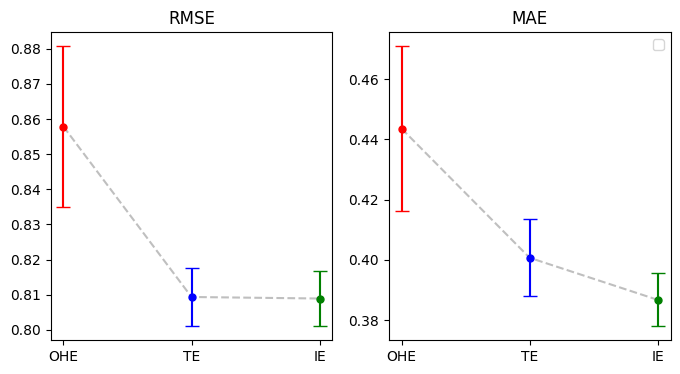

In [53]:
import matplotlib.pyplot as plt

res_temp = res_all

metrics = ['RMSE', 'MAE']
            
            
models = ["OneHotEncoder", "ThermometerEncoder", "IntegerEncoder"]
model_names = ['OHE', 'TE', 'IE']
colors = ['r', 'b', 'g']
fig, ax = plt.subplots(1, 2, figsize=(8,4))
ax = ax.ravel()
for i, metric in enumerate(metrics):
            mean, std = [], []
            for model in models:
                mean.append(res_temp[model][metric][0]), std.append(res_temp[model][metric][1])
            ax[i].errorbar(range(len(models)), mean, std, alpha = 0.5, fmt='--', color = 'grey')    
            for j, model in enumerate(models):
                (_,caps,_)= ax[i].errorbar(j, mean[j], std[j], color = colors[j], alpha = 1, fmt='.', markersize=10, capsize = 5)
                for cap in caps:
                    cap.set_markeredgewidth(1)
for i, axe in enumerate(ax):
    axe.set_title(metrics[i])
    axe.set_xticks(range(len(models)), model_names)
ax[1].legend()       

In [53]:
with open(f'C:/bachelor thesis/{dataset_name}_result/nn_result/bz250_dz3_lr000001_res.csv','w') as f:
    for df in df_lists:
        f.write(f"{df.columns.name}\n")
        df.to_csv(f)
        f.write("\n")

In [16]:
pd.DataFrame(res_all).to_csv('acs_datasource_result/nn_result/bz500_dz3_lr001_res.csv')

In [53]:
# def make_class_ratios(df, features_dic, class_name):
#     length = len(df)
#     print(features_dic['label'][class_name])
#     return [len(df[df['class'] == val])/length for val in features_dic['label'][class_name]]

# datapath = os.path.join(config['dataset']['path'], config['dataset']['name'])
# df, features_dic = open_dataset(datapath, config['dataset']['name'], config['dataset']['name'])
# tr = Trainer(df, features_dic)
# tr.set_ord_enc(get_encoders('ohe')[0])
# tr.set_train_idx(list(range(0,500)))
# tr.set_val_idx(list(range(500,900)))
# tr._set_model([183,122,61], None, [0.7, 0.3])
# tr.model.parameters
# torch.sum(tr.model.hidden_blocks.hidden1.fc.weight)/(61*183)

In [21]:
config['dataset']['name'] = dataset_name
data_path = os.path.join(config["dataset"]["path"], config["dataset"]["name"])
df, features_dic = open_dataset(data_path, config["dataset"]["name"], config["dataset"]["name"])
# train_df, test_df = train_test_split(df, test_size=config['dataset']['split'], random_state=config['dataset']['seed'], stratify=df[features_dic['label'].keys()])

# train_idx, val_idx = list(range(0,700)), list(range(700, 900))

# mode = config['wandb']['mode']
# encoders = get_encoders(config['model']['encoder'])
# project = config['wandb']['project'] if 'project' in config['wandb'] else None
# count = config['wandb']['count'] if 'count' in config['wandb'] else None
# entity = config['wandb']['entity'] if 'entity' in config['wandb'] else None
# trainer = Trainer(train_df.reset_index(drop=True), features_dic)
# save_path = config["model"]["path"]
# model_name = config["model"]["name"]
# trainer.set_model_dir(save_path)
# device = get_device()
# trainer.set_device(device)
# trainer.set_train_idx(train_idx), trainer.set_val_idx(val_idx)
# # if 'continuous' in features_dic:
# #     sc_cont = trainer.process_continuous_data('continuous')
# if not trainer.is_clf:
#     sc_label = trainer.process_continuous_data('label')
# trainer.set_model_name(model_name+'_'+str(1))
# trainer.set_ord_enc(encoders[0])
# # train_log(trainer, mode=mode, config=config['train'], project=project, name=model_name, count=count, entity=entity)
# dl = trainer._set_data_loader(trainer.df.iloc[trainer.train_idx], 5000, True, 0)
# ne = next(iter(dl))

In [22]:
features_dic

{'nominal': {'RAC1P': array([1., 2., 3., 4., 5., 6., 7., 8., 9.]),
  'MAR': array([1., 2., 3., 4., 5.]),
  'COW': array([1., 2., 3., 4., 5., 6., 7., 8.]),
  'SEX': array([1., 2.])},
 'ordinal': {'ENG': array([1., 2., 3., 4.]),
  'WKHP': array([ 1, 11, 21, 31, 41, 51, 61, 71, 81, 91]),
  'AGEP': array([ 0, 10, 20, 30, 40, 50, 60, 70, 80, 90]),
  'SCHL': array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
         14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24.])},
 'step_sizes': {'AGEP': (0, 99, 10), 'WKHP': (1, 99, 10)},
 'label': ['PINCP']}

In [ ]:
# def k_fold_validation(k, config):
#     data_path = os.path.join(config["dataset"]["path"], config["dataset"]["name"])
#     df, features_dic = open_dataset(data_path, config["dataset"]["name"])
#     train_df, test_df = train_test_split(df, test_size=config['dataset']['split'], random_state=config['dataset']['seed'])

#     mode = config['wandb']['mode']
#     encoders = get_encoders(config['model']['encoder'])
#     project = config['wandb']['project'] if 'project' in config['wandb'] else None
#     project_name = config['wandb']['name'] if 'name' in config['wandb'] else None
#     count = config['wandb']['count'] if 'count' in config['wandb'] else None
#     entity = config['wandb']['entity'] if 'entity' in config['wandb'] else None
 
#     trainer = Trainer(train_df.reset_index(drop=True), features_dic)
#     tester = Tester(test_df.reset_index(drop=True), features_dic)
    
#     device = get_device()
#     trainer.set_device(device), tester.set_device(device)
    
#     save_path = config["model"]["path"]
#     model_name = config["model"]["name"]
#     trainer.set_model_dir(save_path)
    
#     kf = KFold(k) 
#     result = {enc.__str__(): [] for enc in encoders} 
#     for i, (train_idx, val_idx) in enumerate(kf.split(train_df)):
#         trainer.set_train_idx(train_idx), trainer.set_val_idx(val_idx)
#         if 'continuous' in features_dic:
#             sc_cont = trainer.process_continuous_data('continuous')
#             tester.process_continuous_data(sc_cont, 'continuous')
#         if not trainer.is_clf:
#             sc_label = trainer.process_continuous_data('label')
#             tester.process_continuous_data(sc_label, 'label')
#         trainer.set_model_name(model_name+'_'+str(i))
#         for encoder in encoders:
#             trainer.set_ord_enc(encoder), tester.set_ord_enc(encoder)
#             train_log(trainer, mode=mode, config=config['train'], project=project, name=project_name+'_'+str(i), count=count, entity=entity)
#             tester.set_model_path(trainer.cur_model_path)
#             config['test']['dim_sizes'] = trainer.dim_sizes
#             cur_res = tester.test(config['test'])
#             result[encoder.__str__()].append(cur_res)
    
    
#     for k, v in result.items():
#         temp = utility.concat_dic(*v)
#         result[k] = utility.mean_std_dic(temp)
        
#     return result